In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import ntpath

import mne
from mne import Epochs, pick_types, find_events, pick_types, set_eeg_reference
from mne.channels import read_layout
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne import viz

import dhedfreader

%matplotlib inline 

In [3]:
ann2label = {
    "Sleep stage W": 0,
    "Sleep stage 1": 1,
    "Sleep stage 2": 2,
    "Sleep stage 3": 3,
    "Sleep stage 4": 3,
    "Sleep stage R": 4,
    "Sleep stage ?": 5,
    "Movement time": 5
}
# Label values
W = 0
N1 = 1
N2 = 2
N3 = 3
REM = 4
UNKNOWN = 5

sampling_rate = 100.0
EPOCH_SEC_SIZE = 30

In [2]:
data_path = r'E:/data_2013'
# single subject
data_files = os.listdir(data_path)

edf_data_files = [i for i in data_files if "Hypnogram" not in i]
hyp_data_files = [i for i in data_files if "Hypnogram" in i]



print(f"Number of PSG files used in analysis:       {len(edf_data_files)} files")
print(f"Number of hypnogram files used in analysis: {len(edf_data_files)} files")

Number of PSG files used in analysis:       39 files
Number of hypnogram files used in analysis: 39 files


In [3]:
# We use mne.read_raw_edf to read in the .edf EEG files
raw = read_raw_edf(psg_files_path, preload=True, stim_channel=None, verbose=False)
raw

<RawEDF  |  SC4051E0-PSG.edf, n_channels x n_times : 7 x 8166000 (81660.0 sec), ~436.1 MB, data loaded>

In [51]:
class_duration = {0:0,1:0,2:0,3:0,4:0}

for i in range(len(edf_data_files)):
#     psg_files_path = os.path.join(data_path, edf_data_files[i])
    hyp_files_path = os.path.join(data_path, hyp_data_files[i])
    
    # Read annotation and its header
    f = open(hyp_files_path, 'r', errors='ignore')
    reader_ann = dhedfreader.BaseEDFReader(f)
    reader_ann.read_header()
    h_ann = reader_ann.header
    _, _, ann = zip(*reader_ann.records())
    f.close()
    ann_start_dt = datetime.strptime(h_ann['date_time'], "%Y-%m-%d %H:%M:%S")

    file_duration_in_sec = ann[0][len(ann[0])-1][0] + ann[0][len(ann[0])-1][1]
    
    # Generate label and remove indices

    for a in ann[0]:
        onset_sec, duration_sec, ann_char = a
        ann_str = ann_char[0][2:-1]
        label = ann2label[ann_str]
        if label != UNKNOWN:
            if duration_sec % EPOCH_SEC_SIZE != 0:
                raise Exception("Something wrong")
            class_duration[label] += duration_sec


In [52]:
class_duration

{0: 2171730.0, 1: 84120.0, 2: 533970.0, 3: 171090.0, 4: 231510.0}

In [6]:
file_length_in_sec = (ann[0][len(ann[0])-1][0] + ann[0][len(ann[0])-1][1])

86400.0

In [7]:
class_duration

{0: 67740.0, 1: 1320.0, 2: 6510.0, 3: 4050.0, 4: 2040.0}

In [8]:
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [16]:
from bokeh.plotting import figure, show

p = figure(plot_width=400, plot_height=400)
p.vbar(x=list(class_duration.keys()), width=0.5, bottom=0,
       top=[*class_duration.values()])#, color="firebrick")
p.xaxis.axis_label = 'Sleep Class'
p.yaxis.axis_label = 'length in seconds'
show(p)

In [53]:
from bokeh.plotting import figure, show

p = figure(plot_width=400, plot_height=400)
p.vbar(x=list(class_duration.keys()), width=0.5, bottom=0,
       top=[*class_duration.values()])#, color="firebrick")
p.xaxis.axis_label = 'Sleep Class'
p.yaxis.axis_label = 'length in seconds'
show(p)

In [54]:
from bokeh.layouts import gridplot
from bokeh.plotting import figure

# Extract data from the first 5 channels, from 1 s to 3 s.
sfreq = raw.info['sfreq']

data = {}
times = {}
ch_names = {}
for ch in range(len(raw.info["chs"])): # 7 channels
    ch_names[ch] = raw.info["chs"][ch]['ch_name']
    data[ch], times[ch] = raw[ch, int(sfreq * 1):int(sfreq * 10)]

#data_1, times_1 = raw[1, int(sfreq * 1):int(sfreq * 10)]

# for i in range(len(raw.info["chs"])):
#     fig = plt.subplots(figsize=(10,8))
#     plt.plot(times[i], data[i].T)
#     plt.xlabel('Seconds')
#     plt.ylabel('$\mu V$')
#     plt.legend([ch_names[i]])
#     plt.show()


# create three plots
s1 = figure()
s1.line(times[0], data[0].squeeze(), color='navy', alpha=0.5, legend=[ch_names[0]])
s2 = figure()
s2.line(times[1], data[1].squeeze(), color='navy', alpha=0.5, legend=[ch_names[1]])
s3 = figure()
s3.line(times[2], data[2].squeeze(), color='navy', alpha=0.5, legend=[ch_names[2]])
# make a grid
grid = gridplot([s1, s2, s3], ncols=1, plot_width=900, plot_height=250)

# show the results
show(grid)

In [35]:
mapping = {'EOG horizontal': 'eog',
           'Resp oro-nasal': 'misc',
           'EMG submental': 'misc',
           'Temp rectal': 'misc',
           'Event marker': 'misc'}

raw_train = mne.io.read_raw_edf(psg_files_path)
annot_train = mne.read_annotations(hyp_files_path)

raw_train.set_annotations(annot_train, emit_warning=False)
raw_train.set_channel_types(mapping)


Extracting EDF parameters from E:\data_2013\SC4051E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


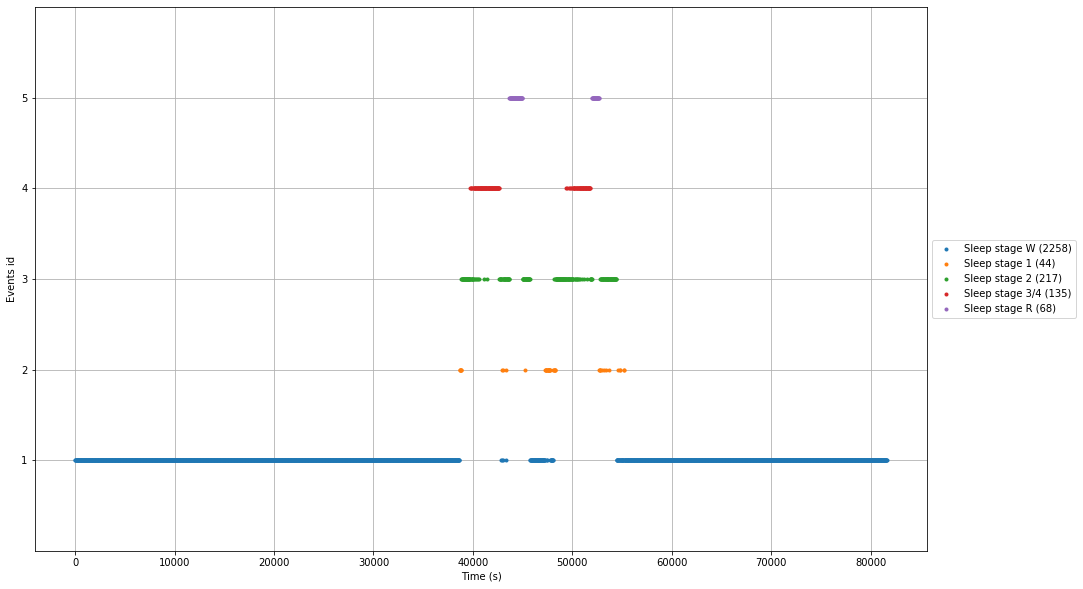

In [46]:
annotation_desc_2_event_id = {'Sleep stage W': 1,
                              'Sleep stage 1': 2,
                              'Sleep stage 2': 3,
                              'Sleep stage 3': 4,
                              'Sleep stage 4': 4,
                              'Sleep stage R': 5}

ann2label = {
    "Sleep stage W": 0,
    "Sleep stage 1": 1,
    "Sleep stage 2": 2,
    "Sleep stage 3": 3,
    "Sleep stage 4": 3,
    "Sleep stage R": 4,
    "Sleep stage ?": 5,
    "Movement time": 5
}

events_train, _ = mne.events_from_annotations(
    raw_train, event_id=annotation_desc_2_event_id, chunk_duration=30.)

# create a new event_id that unifies stages 3 and 4
event_id = {'Sleep stage W': 1,
            'Sleep stage 1': 2,
            'Sleep stage 2': 3,
            'Sleep stage 3/4': 4,
            'Sleep stage R': 5}

# plot events
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
mne.viz.plot_events(events_train, event_id=event_id,axes=axs,
                    sfreq=raw_train.info['sfreq'])

# keep the color-code for further plotting

stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']